In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.manifold import MDS
from sklearn_extra.cluster import KMedoids
import os, pickle

In [2]:
agg_clust_gen4 = pickle.load(open('./Gen4_combined_agg_clusters_explict_solv_False.pkl','rb'))
agg_clust_gen4_noncov_CA = pickle.load(open('./Gen4+CA_REMD_agg_clusters_explict_solv_False.pkl','rb'))
agg_clust_gen4CA = pickle.load(open('./Gen4-CA_explicit_1_agg_clusters_explict_solv_False.pkl','rb'))

In [6]:
### open the data, combine energy with the coords. 
######### RUN THIS CELL 3 TIMES with the different sim versions to load all in
def get_data(path, skip_row, remove=0, explicit=False):
    csv_files = os.listdir(path)
    csv_files = [f for f in csv_files if 'csv' in f]
    csv_energy = sorted([f for f in csv_files if 'energy' in f])
    csv_coords = sorted([f for f in csv_files if 'coords' in f])
    replica_e_data = {}
    replica_c_data = {}
    skip = []
    if explicit:
        reps = [0]
    else:
        reps = [0,1,2,3,4,5,6,7,8,9]
    for c,e,rep in zip(csv_coords, csv_energy, reps):
        if skip_row:
            skip = lambda x:x%10 != 0
        replica_c_data[rep] = pd.read_csv(os.path.join(path,c), skiprows = skip).iloc[remove:,:]
        replica_e_data[rep] = pd.read_csv(os.path.join(path,e), skiprows = skip).iloc[remove:,:]
    return replica_c_data, replica_e_data

def combine_dicts(d1,d2):
    new_dict = {}
    for kv1,kv2 in zip(d1.items(),d2.items()):
        new_dict[kv1[0]] = pd.concat([kv1[1],kv2[1]], axis=0).reset_index().drop(columns='index')
    return new_dict

def int_to_cart(df):
    internal_coord_names = [n for n in list(df) if 'phi' in n or 'psi' in n]
    sin_data = np.sin(df[internal_coord_names]*np.pi/180.0)
    sin_data.columns = [ele+'_y' for ele in internal_coord_names]
    cos_data = np.cos(df[internal_coord_names]*np.pi/180.0)
    cos_data.columns = [ele+'_x' for ele in internal_coord_names]
    df = pd.concat([df, cos_data,sin_data], axis=1).drop(columns=internal_coord_names)
    name_order = ('phi_x', 'phi_y', 'psi_x','psi_y')
    names_not_phipsi = [ele for ele in list(df) if 'phi' not in ele and 'psi' not in ele]
    names = [pp[:-5] for pp in list(df) if 'phi' in pp or 'psi' in pp]
    names = names[:int(len(names)/2):2]
    names_new = []
    for name in names:
        for ele in name_order:
            names_new.append(str(name)+str(ele))
    df = df[names_new+names_not_phipsi]
    return df

##### VERY IMPORANT: WHAT PART OF THE PEPTIDE TO ANALYZE
start = 2
stop = 28 


remove = 1000 # 1000 for the REMD
###### this keeps the frame correct for both of the data sets, but index is over both
path = './REMD_extracted_data/8_1_test32_REMD_1/'
replica_c_data_32, replica_e_data_32 = get_data(path, skip_row=False, remove=remove)
path = './REMD_extracted_data/8_1_test37_REMD_2/'
replica_c_data_37, replica_e_data_37 = get_data(path, skip_row=False, remove=remove)
replica_c_data = combine_dicts(replica_c_data_32, replica_c_data_37)
replica_e_data = combine_dicts(replica_e_data_32, replica_e_data_37)

# path = './REMD_extracted_data/8_1_CA_noncov_REMD/'
# replica_c_data, replica_e_data = get_data(path, skip_row=True, remove=remove)

# path = './REMD_extracted_data/struct81_cov_REMD/'
# replica_c_data, replica_e_data = get_data(path, skip_row=False, remove=remove)

steps = {}
SS = {}
## deal with cases where 'step' or 'Frame' is in df or the other 
for rep in replica_c_data:
    replica_c_data[rep] = int_to_cart(replica_c_data[rep])
    SS[rep] = replica_c_data[rep]['SS']
    if 'step' in replica_c_data[rep]:
        steps[rep] = replica_c_data[rep]['step']
        inds = list(steps[rep].index)
        inds = [remove+ele for ele in inds]
        steps[rep].index=inds
        replica_c_data[rep] = replica_c_data[rep].drop(columns=['step', 'SS'])
        replica_c_data[rep].index=inds
    else:
        steps[rep] = replica_c_data[rep]['Frame']
        inds = list(steps[rep].index)
        inds = [remove+ele for ele in inds]
        steps[rep].index=inds
        replica_c_data[rep] = replica_c_data[rep].drop(columns=['Frame','SS'])
        replica_c_data[rep].index=inds

keep_phipsi = True
subset_phipsi = True ## use all residue or a smaller window, if using phi/psi make this true
keep_dist = False
keep_sasa_rgyr = False
if subset_phipsi:
    resid_subset = [str(i) for i in range(start,stop)]

to_drop = []
sasa_rgyr_names = [n for n in list(replica_c_data[0]) if 'SASA' in n or 'rgyr' in n]
phi_psi_names = [n for n in list(replica_c_data[0]) if 'phi' in n or 'psi' in n]
distance_names = [n for n in list(replica_c_data[0]) if n not in phi_psi_names+sasa_rgyr_names]
if not keep_sasa_rgyr:
    to_drop += sasa_rgyr_names
if not keep_phipsi:
    to_drop += phi_psi_names
if not keep_dist:
    to_drop += distance_names
if subset_phipsi:
    to_drop += [ele for ele in phi_psi_names if ele.split('_')[1] not in resid_subset]
    

rep_c_data_rgyr_sasa = {ele:None for ele in replica_c_data}
rep_c_data_distances = {ele:None for ele in replica_c_data}
for rep in range(10):
    rep_c_data_distances[rep] = replica_c_data[rep][to_drop]
    rep_c_data_rgyr_sasa[rep] = replica_c_data[rep][sasa_rgyr_names]
    replica_c_data[rep] = replica_c_data[rep].drop(columns=to_drop)
        
X_gen4 = replica_c_data[0]
# X_gen4_noncov_CA = replica_c_data[0]
# X_gen4ca = replica_c_data[0]

X_gen4_step = steps[0]
# X_gen4_noncov_CA_step = steps[0]
# X_gen4ca_step = steps[0]

In [7]:
def get_cluster_rep(data):
    kmedoids = KMedoids(n_clusters=1).fit(data)
    center_ind = data.iloc[int(kmedoids.medoid_indices_[0]),:].name
    return kmedoids.cluster_centers_, center_ind

def find_all_clust_reps(data, cluster_obj, random_cluster_eles=50):
    labels = cluster_obj.labels_
    sorted_total_clusters = sorted(list(set(labels)))
    centers = []
    center_inds = []
    cluster_size_fract = []
    total_size = cluster_obj.labels_.shape[0]
    cluster_examples = []
    clusters_for_network = {}
    for i in sorted_total_clusters:
        cluster = data[labels == i]
        cluster_size = cluster.shape[0]
        cluster_size_fract.append(cluster_size/total_size)
        center, cent_ind = get_cluster_rep(cluster)
        elements = [ele for ele in list(cluster.index) if ele != cent_ind]
        if cluster_size < random_cluster_eles:
            cluster_examples.append(elements)
        else:
            elements = list(np.random.choice(elements, random_cluster_eles))
            cluster_examples.append(elements) 
        clusters_for_network[i] = data.loc[elements]
        centers.append(center)
        center_inds.append(cent_ind)
    return centers, cluster_size_fract, center_inds, cluster_examples, clusters_for_network

def example_to_example_frame(step_df, cluster_examples):
    cluster_frames = []
    frames = [list(step_df[ele].values) for ele in cluster_examples]
    return frames  

def make_cluster_df(clust_obj, data, step_df):
    assert data.shape[0] == step_df.shape[0]
    X_centers, cluster_size_fract, center_inds, cluster_examples, clusters_for_network = find_all_clust_reps(data, clust_obj)
    frames = list(step_df.loc[center_inds].values)
    example_frames = example_to_example_frame(step_df, cluster_examples)
    center_size_df = pd.DataFrame({'frame':frames, 'center_index':center_inds, 
                                   'cluster_size':cluster_size_fract, 'example_frames':example_frames})
    return X_centers, center_size_df, clusters_for_network

Xg4_centers, g4center_size_df, g4clusters_for_network = make_cluster_df(agg_clust_gen4, X_gen4, X_gen4_step)
Xg4noncovCA_centers, g4noncovCAcenter_size_df, g4noncovCAclusters_for_network = make_cluster_df(agg_clust_gen4_noncov_CA , X_gen4_noncov_CA, X_gen4_noncov_CA_step)
Xg4CA_centers, g4CAcenter_size_df, g4CAclusters_for_network = make_cluster_df(agg_clust_gen4CA, X_gen4ca, X_gen4ca_step)

In [8]:
Xg4_centers = np.vstack(Xg4_centers)
Xg4CA_centers = np.vstack(Xg4CA_centers)
Xg4noncovCA_centers = np.vstack(Xg4noncovCA_centers)
print(Xg4_centers[:5,:5])

[[ 0.00872587 -0.99996193  0.07216693  0.99739257 -0.08645957]
 [ 0.156468   -0.98768303 -0.79184219  0.61072575 -0.11849195]
 [-0.46521192 -0.88519934 -0.9260476   0.37740673  0.57983201]
 [ 0.02344565 -0.99972511 -0.75905144  0.65103066  0.23403756]
 [-0.17924612 -0.98380426 -0.72819175  0.68537345  0.01845466]]


In [9]:
def get_cluster_size(clustered):
    unique, counts = np.unique(clustered.labels_, return_counts=True)
    sizes = dict(zip(unique, counts))
    return sizes

agg_clust_size = get_cluster_size(agg_clust_gen4)
agg_clust_size_sorted = sorted([(k,v) for k,v in agg_clust_size.items()],reverse=True, key=lambda x:x[1])
reorder_mat = [ele[0] for ele in agg_clust_size_sorted]
Xg4_centers = Xg4_centers[reorder_mat,:]

agg_clust_size = get_cluster_size(agg_clust_gen4_noncov_CA)
agg_clust_size_sorted = sorted([(k,v) for k,v in agg_clust_size.items()],reverse=True, key=lambda x:x[1])
reorder_mat = [ele[0] for ele in agg_clust_size_sorted]
Xg4noncovCA_centers = Xg4noncovCA_centers[reorder_mat,:]

agg_clust_size = get_cluster_size(agg_clust_gen4CA)
agg_clust_size_sorted = sorted([(k,v) for k,v in agg_clust_size.items()],reverse=True, key=lambda x:x[1])
reorder_mat = [ele[0] for ele in agg_clust_size_sorted]
Xg4CA_centers = Xg4CA_centers[reorder_mat,:]


In [10]:
from scipy.spatial.distance import cdist

g4_to_g4nonCA_centers = cdist(Xg4_centers,Xg4noncovCA_centers)
g4_to_g4CA_centers = cdist(Xg4_centers,Xg4CA_centers)
g4nonCA_to_g4CA_centers = cdist(Xg4noncovCA_centers,Xg4CA_centers)

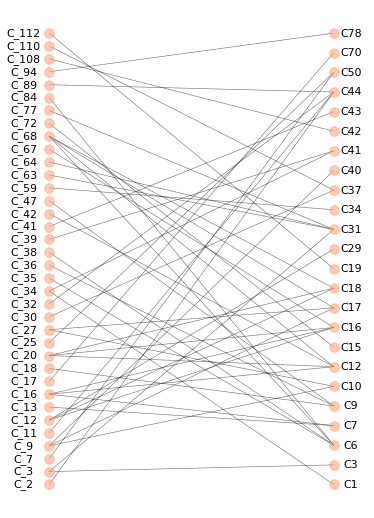

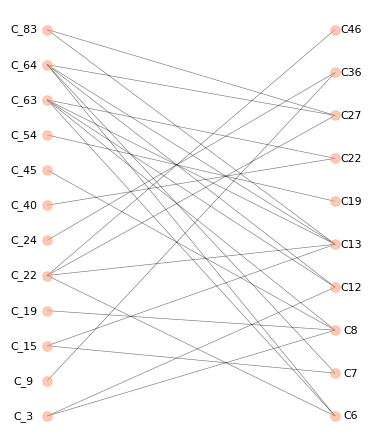

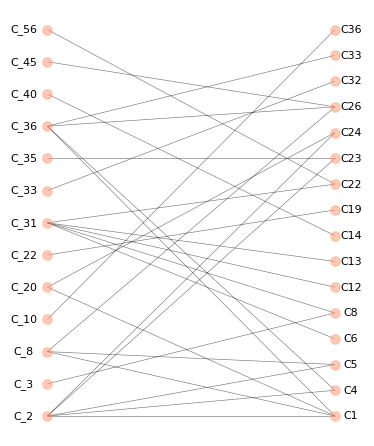

In [35]:
from networkx.algorithms import bipartite
from networkx.drawing.nx_agraph import graphviz_layout
import networkx as nx
dist_max = 3

g4_g4nonca_close = np.argwhere(g4_to_g4nonCA_centers < dist_max).tolist()
g4_g4ca_close = np.argwhere(g4_to_g4CA_centers < dist_max).tolist()
g4nonca_g4ca_close = np.argwhere(g4nonCA_to_g4CA_centers < dist_max).tolist()

first = True
for edges,sim_to_sim,s_name in zip([g4_g4nonca_close,g4_g4ca_close,g4nonca_g4ca_close],[g4_to_g4nonCA_centers,g4_to_g4CA_centers,g4nonCA_to_g4CA_centers],['Gen4_Gen4_noncovCA', 'Gen4_Gen4_covCA','Gen4_noncovCA_Gen4_covCA']):
    B = nx.Graph()
    edges = [['C_'+str(e[0]+1),'C'+str(e[1]+1)] for e in edges]
    B.add_nodes_from([i[0] for i in edges], bipartite=0)
    B.add_nodes_from([j[1] for j in edges], bipartite=1)
    first_edges = sorted([e[0] for e in edges])
    second_edges = sorted([e[1] for e in edges])
    for e in edges:
        B.add_edges_from(edges)
    pos = nx.bipartite_layout(B,sorted([i[0] for i in edges]))
    positions = [[k,v] for k,v in pos.items()]
    n_f = sorted([ele[0] for ele in positions if '_' in ele[0]], key=lambda X:int(X[2:]))
    n_s = sorted([ele[0] for ele in positions if '_' not in ele[0]], key=lambda X:int(X[1:]))
    position_f = [ele[1] for ele in positions if '_' in ele[0]]
    position_s = [ele[1] for ele in positions if '_' not in ele[0]]
    p_f_2 = [ele[1] for ele in position_f]
    p_s_2 = [ele[1] for ele in position_s]
    f_x = position_f[0][0]
    s_x = position_s[0][0]
    pos_f = {}
    lab_pos = {}
    cyc = 0
    for ys, names in zip([p_f_2,p_s_2],[n_f, n_s]):
        for y, n in zip(ys, names):
            if cyc == 0:
                pos_f[n] = np.asarray([f_x,y])
                lab_pos[n] = np.asarray([f_x-0.15,y])
            else:
                pos_f[n] = np.asarray([s_x,y])
                lab_pos[n] = np.asarray([s_x+0.1,y])
        cyc += 1
    if first:
        plt.figure(figsize=(5,7))
        first = False
    else:
        plt.figure(figsize=(5,6))
    nx.draw(B,pos_f,node_size=90,alpha=0.55, #e/2 WITH and CA      [e/3 for e in reorder_size]
        node_color="lightsalmon", with_labels=False, width=0.6, font_size=11) # font 12  WITH and CA
#     nx.draw_networkx_labels(B,lab_pos, width=0.5, font_size=11) # font 12  WITH and CA
    nx.draw(B,lab_pos,node_size=0,alpha=1, #e/2 WITH and CA      [e/3 for e in reorder_size]
        with_labels=True, width=0, font_size=11) # font 12  WITH and CA
    plt.savefig('{}_sim_to_sim_change.svg'.format(s_name), format='svg', dpi=1000, bbox_inches='tight')
    plt.show()

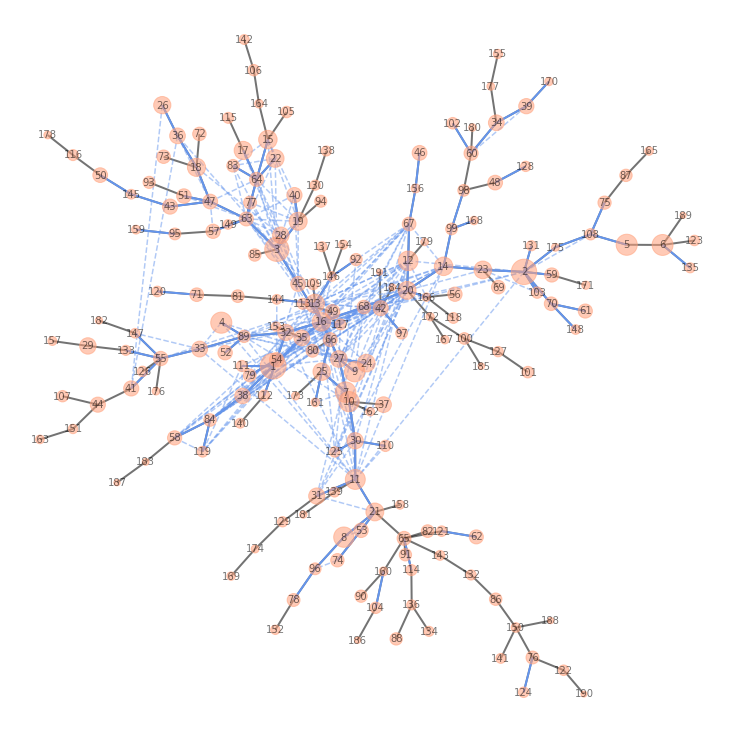

In [246]:
from networkx.drawing.nx_agraph import graphviz_layout
import networkx as nx
from scipy.cluster import hierarchy

save_cell = True

distances = squareform(pdist(X_centers))
distances = distances[:,reorder_mat]
distances = distances[reorder_mat,:]

from networkx.algorithms import approximation
G = nx.from_numpy_matrix(distances)
G_add = nx.from_numpy_matrix(distances)
G_high = nx.from_numpy_matrix(distances)
G = approximation.steiner_tree(G, [i for i in range(distances.shape[0])])
### get the additional edges you want to add with distances < X
mapping = {n:n+1 for n in G}
G = nx.relabel_nodes(G, mapping)
pos=graphviz_layout(G,prog='neato',args='')

to_remove = []
for i in range(distances.shape[0]):
    for j in range(distances.shape[0]):
        if distances[i,j] > 4:
            to_remove.append((i,j))
            to_remove.append((j,i))
for ele in to_remove:
    try:
        G_add.remove_edge(*ele)
        G_high.remove_edge(*ele)
    except:
        pass
mapping = {n:n+1 for n in G_add}
G_add = nx.relabel_nodes(G_add, mapping)    
G_high = nx.relabel_nodes(G_high, mapping) 
for e in G_add.edges():
    if e in G.edges():
        G_add.remove_edge(*e) 
for e in G_high.edges():
#     print(e)
    if e not in G.edges():
        G_high.remove_edge(*e)
pos_add = {n:pos[n] for n in G_add.nodes()}
pos_high = {n:pos[n] for n in G_high.nodes()}
plt.figure(figsize=(10,10))
# nx.draw(G,pos, node_size=[e/2 for e in reorder_size],alpha=0.6,
#         node_color="skyblue", with_labels=True, width=2, font_size=14)
# nx.draw_networkx_edges(G_add, pos_add, style='dashed', alpha=0.35, width=1.5, edge_color='red')
# nx.draw_networkx_edges(G_high, pos_high,edge_color='red', width=2)
nx.draw(G,pos, node_size=[e/3 for e in reorder_size],alpha=0.55, #e/2 WITH and CA
        node_color="lightsalmon", with_labels=True, width=2, font_size=10) # font 12  WITH and CA
nx.draw_networkx_edges(G_add, pos_add, style='dashed', alpha=0.5, width=1.5, edge_color='cornflowerblue') #width 2  WITH and CA
nx.draw_networkx_edges(G_high, pos_high,edge_color='cornflowerblue', width=2) # width 2.5 WITH and CA
if save_cell:
    plt.savefig('{}_cluster_graph_{}-to-{}.svg'.format(save_name,start,stop), format='svg', dpi=1000, bbox_inches='tight')
plt.show()





#neato, dot, twopi, circo, fdp, nop, wc, acyclic, gvpr, gvcolor, ccomps, sccmap, tred, s